<a href="https://colab.research.google.com/github/tomafischer/ai_geeks/blob/main/deeplearning/torch_ANN_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
###
#  Data Loader
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__
###
from torch.utils.data import Dataset, DataLoader

class Simple_DataSet(Dataset):
  def __init__(self, length = 1000 ):
    self.length = length
    self.x = None
    self.y = None

  def __len__(self):
    return self.length
  
  def __getitem__(self, idx):
    #print(f"getitem: {idx}")
    return self.x[idx], self.y[idx]
    
  def calc_values(self, interval, func, length):
    self.length = length
    self.x = np.linspace(interval[0], interval[1], self.length)
    self.y = func(self.x)
    
  

In [ ]:
a = Simple_DataSet() 
a.calc_values(interval =[0,4], func= np.sin, length= 20 )
print(len(a))
print(a[0:-1])
b = torch.zeros(3)
b[0] =a[1][1]
print(b)
type(a[1][1])


20
(array([0.        , 0.21052632, 0.42105263, 0.63157895, 0.84210526,
       1.05263158, 1.26315789, 1.47368421, 1.68421053, 1.89473684,
       2.10526316, 2.31578947, 2.52631579, 2.73684211, 2.94736842,
       3.15789474, 3.36842105, 3.57894737, 3.78947368]), array([ 0.        ,  0.20897462,  0.40872137,  0.59041986,  0.74604665,
        0.86872962,  0.95305133,  0.99528832,  0.9935755 ,  0.9479885 ,
        0.86054034,  0.73509255,  0.57718464,  0.39378948,  0.19300541,
       -0.01630136, -0.2248883 , -0.42354465, -0.60349817]))
tensor([0.2090, 0.0000, 0.0000])


numpy.float64

In [ ]:
import unittest
class Test_Simple_DataSet(unittest.TestCase):
  def test_Simple_DataSet_array(self):
    dl = Simple_DataSet()
    dl.calc_values(interval =[0,4], func= np.sin, length= 200 )
    self.assertEqual(dl.x[0], 0)
    self.assertEqual(dl.x[-1], 4)
    self.assertEqual(len(dl), 200)
    self.assertEqual(dl.y[0], np.sin(0))
    
    
    #self.assertEqual()
unittest.main(argv=[''], verbosity=2, exit=False)

test_Simple_DataLoader_array (__main__.Test_Simple_DataLoader) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [ ]:
####
# define model
####
class ANN_default(nn.Module):
  def __init__(self):
    super(ANN_default, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(1,10),
      nn.ReLU(),
      nn.Linear(10,5),
      nn.ReLU(),
      nn.Linear(5,10),
      nn.ReLU(),
      nn.Linear(10,1)
    )
    
  def forward(self, x):
    logits = self.model(x)
    return logits

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
  
# model = ANN_default().to(device)
# print(model)
  

Using cpu device


In [ ]:
###
#   Data prep
####
def create_1Dim_linear_data(slope, N=50):
  x = torch.randn(N,1)
  y = slope * x + torch.randn(N,1)/2
  return x,y

##getting training dataset
def create_1Dim_linear_dataloader(slope = 0.5, N= 50, batch_size = 50):
  # create DataSet
  ds = Simple_DataSet()
  ds.x, ds.y = create_1Dim_linear_data(slope= slope, N=N)
  ds.length = N
  #create DataLoader
  dl =  DataLoader(dataset=ds, batch_size=batch_size)
  return dl

##testing
class Test_1Dim_linear_dataloader(unittest.TestCase):
  def test_1Dim_linear_dataloader(self):
    dl = create_1Dim_linear_dataloader(slope = 0.4, N= 40, batch_size = 40)
    self.assertEqual(len(dl.dataset), 40)
    self.assertEqual(dl.batch_size, 40)
    self.assertEqual(len(dl.dataset.x), 40)
unittest.main(argv=[''], verbosity=2, exit=False)    

test_1Dim_linear_dataloader (__main__.Test_1Dim_linear_dataloader) ... ok
test_Simple_DataLoader_array (__main__.Test_Simple_DataLoader) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


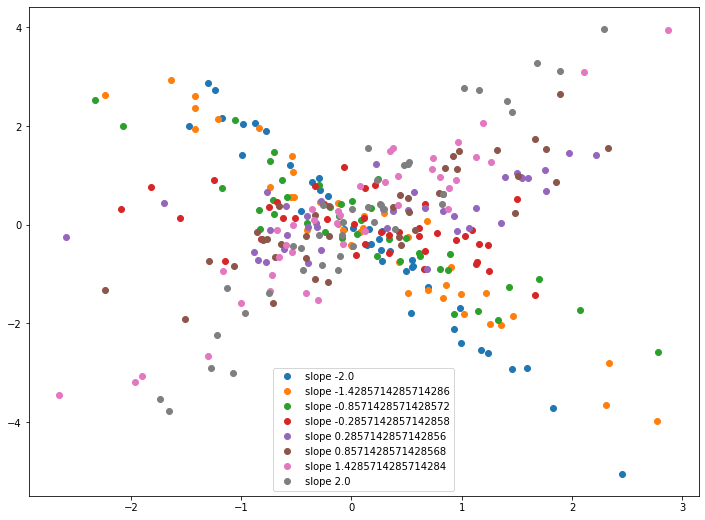

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(12,9))
ax = axs
slopes = np.linspace(-2,2,8)
for slope in slopes:
  dl = create_1Dim_linear_dataloader(slope = slope, N= 40, batch_size = 40)
  ax.plot(dl.dataset.x, dl.dataset.y, 'o',label=f"slope {slope}")
plt.legend()
plt.show()

In [ ]:
# train_dl = create_1Dim_linear_dataloader(slope=0.5, N=50, batch_size = 50)
# print(len(train_dl.dataset))

50


In [ ]:
# t = torch.Tensor(1)
# t.add_(1)
# t.add_(2)
# t

tensor([3.])

In [ ]:
def train(train_dl : DataLoader, test_dl: DataLoader, model, loss_fn, optimizer, epochs = 1, device = 'cpu', 
          print_batch_mod = 100, calculate_full_training_loss_each_epoch= True, verbose= True):
  size = len(train_dl.dataset)
  batch_size = train_dl.batch_size
  print(f"size: {size}, batch_size: {batch_size}, epochs: {epochs}, print_batch_mod: {print_batch_mod}")
  #getting losses tensor
  losses = [] 
  losses_epoch = []
  (x_test,y_test) = test_dl.dataset[:]
  
  #iterating through epocks
  for epoch in range(epochs):
    if verbose:
      print(f"\nEpoch: {epoch + 1}")
    for batch, (x,y) in enumerate(train_dl):
      x,y = x.to(device), y.to(device)

      # forward pass - compute prediction
      pred = model(x)
      # compute loss
      loss = loss_fn(pred, y)
      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      losses.append(loss.item())
      #i += 1
      
      # printing progress
      if verbose:
        if batch % print_batch_mod == 0:
          loss, current, total_batches = loss.item(), batch + 1, int(size/batch_size) 
          print(f"Epoch: [{epoch + 1}/{epochs}], Batch: [{current}/{total_batches}], [{current * batch_size}/{size}], batch loss: {loss}" )
    #at the end of the epoch we can calculate the full model loss
    if calculate_full_training_loss_each_epoch:
      with torch.no_grad(): 
        pred_test = model(x_test)
        loss_test= loss_fn(pred_test,y_test)
        losses_epoch.append(loss_test.item())
        if verbose:
          print(f"Epochloss testdata: [{epoch + 1}/{epochs}]: {loss_test}" )
      
  return losses_epoch,losses

size: 189, batch_size: 400, epochs: 400, print_batch_mod: 1

Epoch: 1
Epoch: [1/400], Batch: [1/0], [400/189], batch loss: 0.2824489176273346
Epochloss testdata: [1/400]: 0.3638322651386261

Epoch: 2
Epoch: [2/400], Batch: [1/0], [400/189], batch loss: 0.27459993958473206
Epochloss testdata: [2/400]: 0.35773658752441406

Epoch: 3
Epoch: [3/400], Batch: [1/0], [400/189], batch loss: 0.26783350110054016
Epochloss testdata: [3/400]: 0.35240960121154785

Epoch: 4
Epoch: [4/400], Batch: [1/0], [400/189], batch loss: 0.26194584369659424
Epochloss testdata: [4/400]: 0.34774306416511536

Epoch: 5
Epoch: [5/400], Batch: [1/0], [400/189], batch loss: 0.25683560967445374
Epochloss testdata: [5/400]: 0.3436357080936432

Epoch: 6
Epoch: [6/400], Batch: [1/0], [400/189], batch loss: 0.25237563252449036
Epochloss testdata: [6/400]: 0.33997616171836853

Epoch: 7
Epoch: [7/400], Batch: [1/0], [400/189], batch loss: 0.24845005571842194
Epochloss testdata: [7/400]: 0.3366275429725647

Epoch: 8
Epoch: [8/

Epoch: [115/400], Batch: [1/0], [400/189], batch loss: 0.19920235872268677
Epochloss testdata: [115/400]: 0.28038057684898376

Epoch: 116
Epoch: [116/400], Batch: [1/0], [400/189], batch loss: 0.19915708899497986
Epochloss testdata: [116/400]: 0.28030097484588623

Epoch: 117
Epoch: [117/400], Batch: [1/0], [400/189], batch loss: 0.19911277294158936
Epochloss testdata: [117/400]: 0.28022292256355286

Epoch: 118
Epoch: [118/400], Batch: [1/0], [400/189], batch loss: 0.19906935095787048
Epochloss testdata: [118/400]: 0.2801463305950165

Epoch: 119
Epoch: [119/400], Batch: [1/0], [400/189], batch loss: 0.19902682304382324
Epochloss testdata: [119/400]: 0.2800712585449219

Epoch: 120
Epoch: [120/400], Batch: [1/0], [400/189], batch loss: 0.19898514449596405
Epochloss testdata: [120/400]: 0.27999764680862427

Epoch: 121
Epoch: [121/400], Batch: [1/0], [400/189], batch loss: 0.1989443302154541
Epochloss testdata: [121/400]: 0.2799254357814789

Epoch: 122
Epoch: [122/400], Batch: [1/0], [400/1

Epoch: [229/400], Batch: [1/0], [400/189], batch loss: 0.19795483350753784
Epochloss testdata: [229/400]: 0.2778832018375397

Epoch: 230
Epoch: [230/400], Batch: [1/0], [400/189], batch loss: 0.19795472919940948
Epochloss testdata: [230/400]: 0.2778812050819397

Epoch: 231
Epoch: [231/400], Batch: [1/0], [400/189], batch loss: 0.19795459508895874
Epochloss testdata: [231/400]: 0.2778792083263397

Epoch: 232
Epoch: [232/400], Batch: [1/0], [400/189], batch loss: 0.1979544758796692
Epochloss testdata: [232/400]: 0.27787724137306213

Epoch: 233
Epoch: [233/400], Batch: [1/0], [400/189], batch loss: 0.19795437157154083
Epochloss testdata: [233/400]: 0.27787530422210693

Epoch: 234
Epoch: [234/400], Batch: [1/0], [400/189], batch loss: 0.1979542225599289
Epochloss testdata: [234/400]: 0.2778733968734741

Epoch: 235
Epoch: [235/400], Batch: [1/0], [400/189], batch loss: 0.19795413315296173
Epochloss testdata: [235/400]: 0.27787142992019653

Epoch: 236
Epoch: [236/400], Batch: [1/0], [400/189

Epoch: [369/400], Batch: [1/0], [400/189], batch loss: 0.1979413777589798
Epochloss testdata: [369/400]: 0.27772024273872375

Epoch: 370
Epoch: [370/400], Batch: [1/0], [400/189], batch loss: 0.19794127345085144
Epochloss testdata: [370/400]: 0.277719646692276

Epoch: 371
Epoch: [371/400], Batch: [1/0], [400/189], batch loss: 0.19794116914272308
Epochloss testdata: [371/400]: 0.27771905064582825

Epoch: 372
Epoch: [372/400], Batch: [1/0], [400/189], batch loss: 0.1979411095380783
Epochloss testdata: [372/400]: 0.2777184844017029

Epoch: 373
Epoch: [373/400], Batch: [1/0], [400/189], batch loss: 0.19794103503227234
Epochloss testdata: [373/400]: 0.2777178883552551

Epoch: 374
Epoch: [374/400], Batch: [1/0], [400/189], batch loss: 0.19794094562530518
Epochloss testdata: [374/400]: 0.27771732211112976

Epoch: 375
Epoch: [375/400], Batch: [1/0], [400/189], batch loss: 0.1979408711194992
Epochloss testdata: [375/400]: 0.2777167856693268

Epoch: 376
Epoch: [376/400], Batch: [1/0], [400/189],

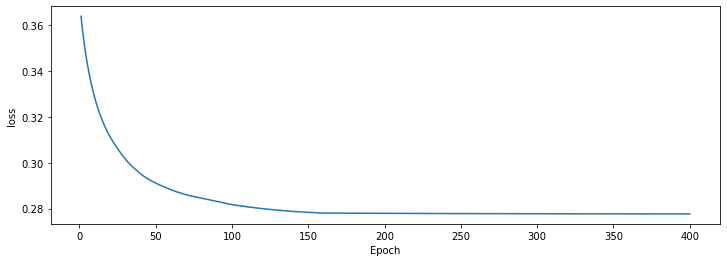

In [ ]:
model1 = ANN_default()
model1.model = nn.Sequential(
      nn.Linear(1,1),
      nn.ReLU(),
      nn.Linear(1,1)
    ) 
model1 = model1.to(device)
batch_size = 400
epochs = 400
train_dl = create_1Dim_linear_dataloader(slope=0.05, N=189, batch_size = batch_size)
test_dl = create_1Dim_linear_dataloader(slope=0.1, N=189, batch_size = batch_size)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr= .05)

print_batch_mod = 1
device = device

losses_epoch,losses = train(train_dl = train_dl, test_dl= test_dl, model = model1, loss_fn= loss_fn, optimizer = optimizer, 
               epochs = epochs, device = device, print_batch_mod = print_batch_mod,
              calculate_full_training_loss_each_epoch = True)

#plotting the losses
x_loss = np.linspace(1,len(losses_epoch),len(losses_epoch))
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax = ax
ax.plot(x_loss,losses_epoch)
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')
plt.show()

In [ ]:
np.linspace(1,len(losses_epoch),len(losses_epoch))


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

In [ ]:
def calc_losses_and_Pearson_correlation_coefficients(model, x, y, loss_fn, verbose=True ):
  # calculate the losses
  pred = None
  loss = None
  with torch.no_grad():
    pred = model(x)
    loss = loss_fn(pred, y)
  correlation_coefficient = np.corrcoef(y.T, pred.T)[0,1]
  if verbose:
    print(f"loss {loss:.4f}, correlation coefficient: {correlation_coefficient:0.3f}")
  return loss.item(), correlation_coefficient


In [ ]:
calc_losses_and_Pearson_correlation_coefficients(model1, train_dl.dataset.x,train_dl.dataset.y, loss_fn)

loss 0.1979, correlation coefficient: 0.088


(0.1979387104511261, 0.08793469929140957)

In [ ]:
def run_experiment(numExps,slopes):
  results = np.zeros((len(slopes), numExps, 2))
  for slopei in range(len(slopes)):
    for N in range(numExps):
      ###getting models and data
      model1 = ANN_default()
      model1.model = nn.Sequential(
      nn.Linear(1,1),
      nn.ReLU(),
      nn.Linear(1,1)
        ) 
    
      batch_size = 400
      epochs = 400
      train_dl = create_1Dim_linear_dataloader(slope=slopes[slopei], N=100, batch_size = batch_size)
      
      loss_fn = nn.MSELoss()
      optimizer = torch.optim.SGD(model1.parameters(), lr= .05)

      print_batch_mod = False
      device = 'cpu'

      losses_epoch,losses = train(train_dl = train_dl, test_dl= train_dl, model = model1, loss_fn= loss_fn, optimizer = optimizer, 
               epochs = epochs, device = device, print_batch_mod = print_batch_mod,
              calculate_full_training_loss_each_epoch = True, verbose=False)
      
      
      #calculate losses and correlation
      loss, cor= calc_losses_and_Pearson_correlation_coefficients(model1, train_dl.dataset.x,train_dl.dataset.y, loss_fn)
      #losse
      results[slopei,N,0]= loss
      #corrcoef
      results[slopei,N,1] = cor
  #create data
  #train_dl = create_1Dim_linear_dataloader(slope=0.05, N=500, batch_size = 50)
  
  # correlation can be 0 if the model didn't do well. Set nan's->0
  results[np.isnan(results)] = 0
  return results


In [ ]:
slopes = np.linspace(-2,2,8)
exp_results = run_experiment(numExps=50, slopes= slopes)

size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2606, correlation coefficient: 0.971
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.3018, correlation coefficient: 0.966
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2847, correlation coefficient: 0.966
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2298, correlation coefficient: 0.967
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False


/Users/tfischer/opt/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/tfischer/opt/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


loss 3.6319, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2425, correlation coefficient: 0.971
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2819, correlation coefficient: 0.971
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2250, correlation coefficient: 0.977
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 4.9187, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2818, correlation coefficient: 0.966
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.3924, correlation coefficient: 0.961
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.1915, correlation coefficient: 0.974
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2658, correlation coefficient: 0.974
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 4.9545, correlation coeffic

loss 0.2700, correlation coefficient: 0.936
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2832, correlation coefficient: 0.941
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 1.9261, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.1978, correlation coefficient: 0.938
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 2.7063, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2837, correlation coefficient: 0.925
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2542, correlation coefficient: 0.935
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2609, correlation coefficient: 0.939
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2255, correlation coefficient: 0.952
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2861, correlation coeffic

loss 0.2335, correlation coefficient: 0.548
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2211, correlation coefficient: 0.516
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2321, correlation coefficient: 0.516
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.4376, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2273, correlation coefficient: 0.470
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2049, correlation coefficient: 0.484
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2511, correlation coefficient: 0.315
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2144, correlation coefficient: 0.506
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2551, correlation coefficient: 0.510
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2320, correlation coeff

loss 0.3443, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2311, correlation coefficient: 0.315
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2374, correlation coefficient: 0.540
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2906, correlation coefficient: 0.495
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.3615, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2387, correlation coefficient: 0.468
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.3816, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2309, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.3449, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.3595, correlation coefficient: 

loss 2.5279, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2331, correlation coefficient: 0.948
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.3040, correlation coefficient: 0.943
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 2.1992, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2700, correlation coefficient: 0.916
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 1.9288, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2969, correlation coefficient: 0.934
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.3721, correlation coefficient: 0.864
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 2.5544, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2827, correlation coefficient

loss 0.2096, correlation coefficient: 0.973
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 3.9674, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2609, correlation coefficient: 0.967
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2851, correlation coefficient: 0.959
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 4.0329, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.1853, correlation coefficient: 0.978
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2392, correlation coefficient: 0.971
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.3127, correlation coefficient: 0.963
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 3.7199, correlation coefficient: nan
size: 100, batch_size: 400, epochs: 400, print_batch_mod: False
loss 0.2512, correlation coefficie

Text(0.5, 1.0, 'Model performance')

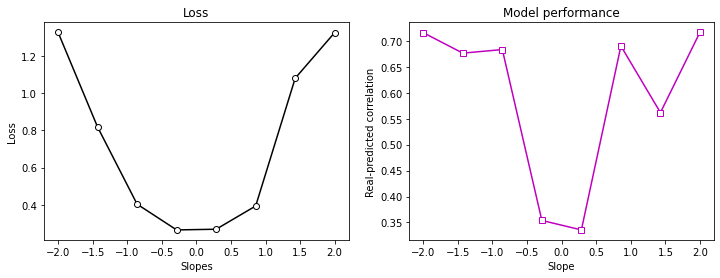

In [ ]:
#plot the results
fix, axs = plt.subplots(1,2,figsize =(12,4))
ax = axs[0]
ax.plot(slopes,np.mean(exp_results[:,:,0],axis=1),'ko-', markerfacecolor='w')
ax.set_xlabel("Slopes")
ax.set_ylabel("Loss")
ax.set_title('Loss')

ax = axs[1]
ax.plot(slopes, np.mean(exp_results[:,:,1],axis=1), 'ms-', markerfacecolor = 'w')
ax.set_xlabel('Slope')
ax.set_ylabel('Real-predicted correlation')
ax.set_title('Model performance')

In [ ]:
exp_results[:,:,0]

array([[-2.        , -2.        , -2.        ],
       [-1.42857143, -1.42857143, -1.42857143],
       [-0.85714286, -0.85714286, -0.85714286],
       [-0.28571429, -0.28571429, -0.28571429],
       [ 0.28571429,  0.28571429,  0.28571429],
       [ 0.85714286,  0.85714286,  0.85714286],
       [ 1.42857143,  1.42857143,  1.42857143],
       [ 2.        ,  2.        ,  2.        ]])

In [ ]:
np.mean(exp_results[:,:,0],axis=1)

array([-2.        , -1.42857143, -0.85714286, -0.28571429,  0.28571429,
        0.85714286,  1.42857143,  2.        ])

Text(0.5, 1.0, 'Model performance')

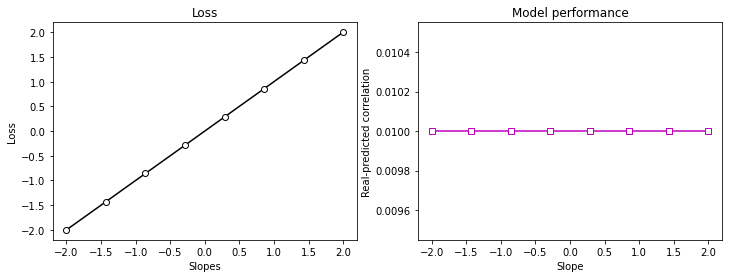

In [ ]:
train_dl = create_1Dim_linear_dataloader(slope=0.05, N=500, batch_size = 50)

tensor([0.3436])

In [ ]:
a = torch.zeros(5)
a[0]= train_dl.dataset[0][1]
a

tensor([0.3436, 0.0000, 0.0000, 0.0000, 0.0000])